## Zadanie 1

Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

In [2]:
import torch
import torch.nn as nn  # conv layers
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

Device: mps


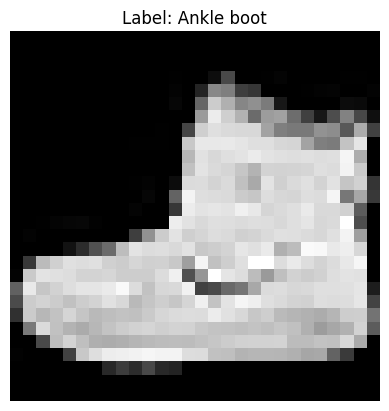

In [3]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes
image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

In [4]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(8 * 13 * 13, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)


class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        # dropout between the 1st and 2nd (last) fc layers
        return self.fc2(x)

In [5]:
import numpy as np
import time

def train_model(model, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    losses = []

    start = time.time()

    for epoch in range(epochs):
        model.train()  # set training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, loss: {avg_loss:.4f}")

        end = time.time()
        print(f'Elapsed: {(end - start):.4} (sec)')

    return losses


def evaluate_model(model):
    model.eval()  # set test mode

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [6]:
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns


def run_and_report(model_class, name):
    print(f"\n=== {name} ===")
    model = model_class()
    losses = train_model(model)

    # loss plot
    plt.plot(losses)
    plt.title(f"{name} - loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    # eval
    y_true, y_pred = evaluate_model(model)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - CM")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # choose an example of a wrongly classified clothing
    wrong_idx = np.where(y_true != y_pred)[0]
    if len(wrong_idx) > 0:
        idx = random.choice(wrong_idx)
        img = test_dataset[idx][0].squeeze()
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {class_names[y_pred[idx]]}, True: {class_names[y_true[idx]]}")
        plt.show()


=== CNN 1 ===
Epoch 1, loss: 0.4999
Elapsed: 3.607 (sec)
Epoch 2, loss: 0.3575
Elapsed: 6.967 (sec)
Epoch 3, loss: 0.3267
Elapsed: 10.35 (sec)
Epoch 4, loss: 0.3067
Elapsed: 13.69 (sec)
Epoch 5, loss: 0.2942
Elapsed: 17.13 (sec)


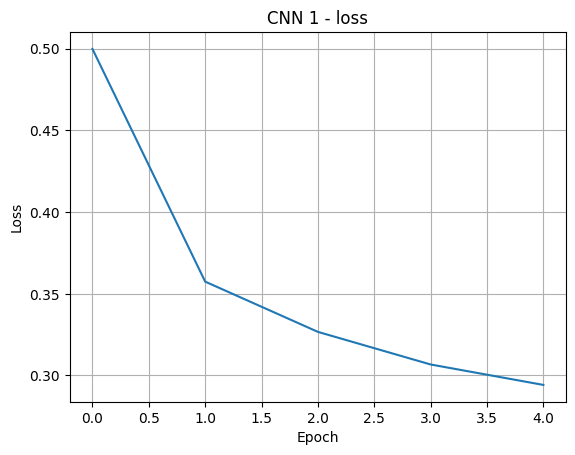

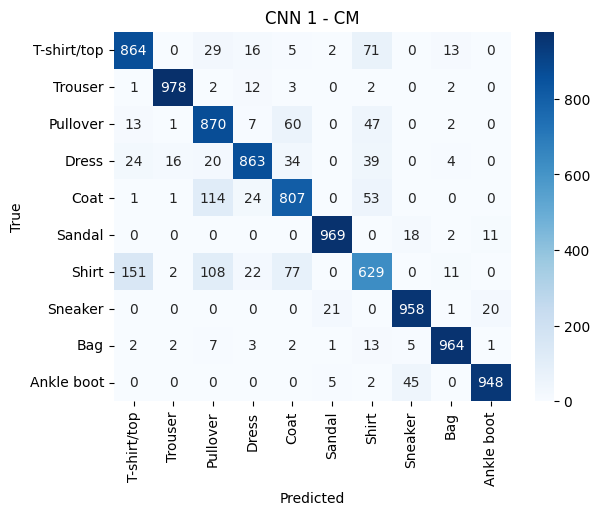

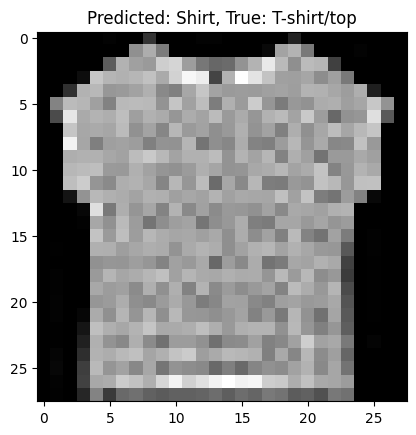


=== CNN 2 ===
Epoch 1, loss: 0.5333
Elapsed: 5.169 (sec)
Epoch 2, loss: 0.3636
Elapsed: 10.22 (sec)
Epoch 3, loss: 0.3206
Elapsed: 15.29 (sec)
Epoch 4, loss: 0.2962
Elapsed: 20.33 (sec)
Epoch 5, loss: 0.2797
Elapsed: 25.47 (sec)


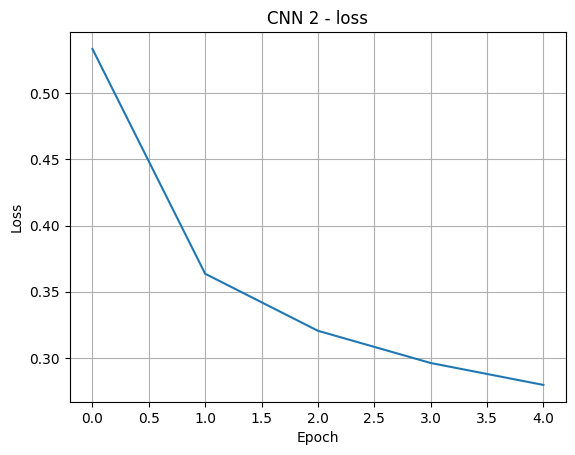

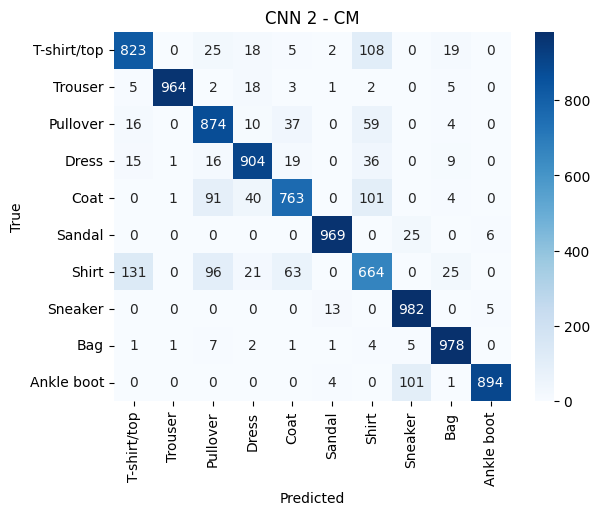

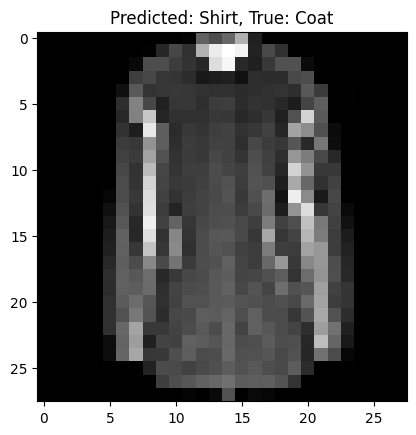


=== CNN 3 ===
Epoch 1, loss: 0.5074
Elapsed: 6.321 (sec)
Epoch 2, loss: 0.3336
Elapsed: 12.68 (sec)
Epoch 3, loss: 0.2880
Elapsed: 19.11 (sec)
Epoch 4, loss: 0.2574
Elapsed: 25.41 (sec)
Epoch 5, loss: 0.2345
Elapsed: 31.76 (sec)


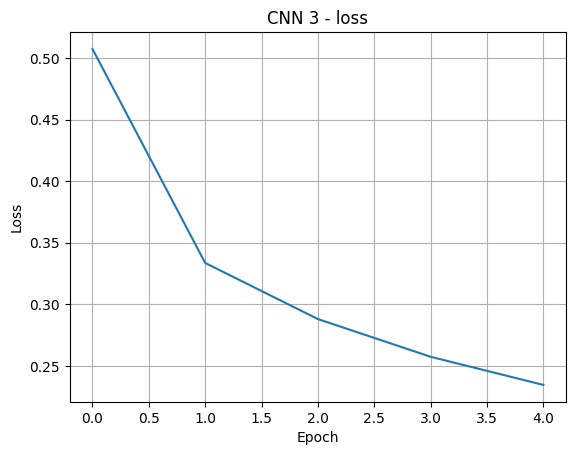

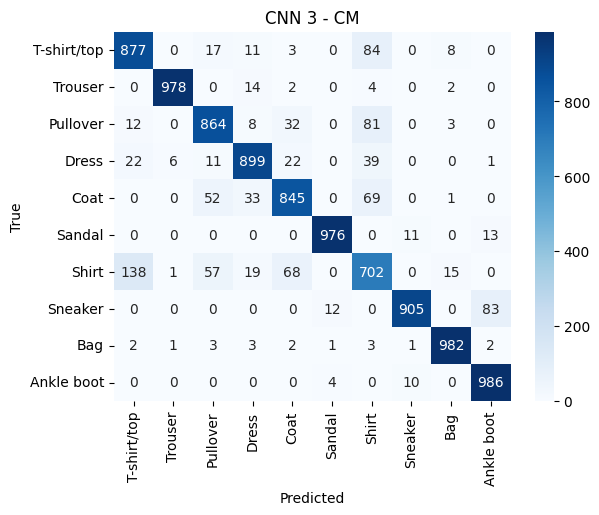

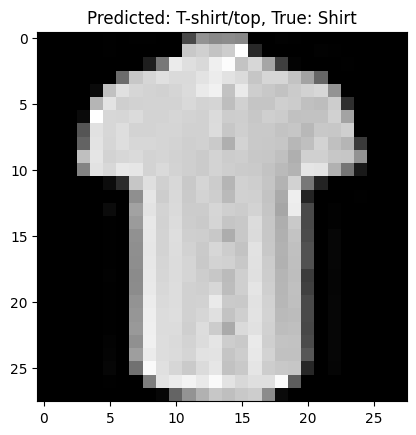

In [7]:
run_and_report(CNN1, "CNN 1")
run_and_report(CNN2, "CNN 2")
run_and_report(CNN3, "CNN 3")